In [1]:
import pickle
import itertools
import random
from collections import Counter
import joblib
import pandas as pd
import numpy as np
import re
from keras import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from parsivar import Normalizer
import emoji
import emojies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [2]:
class CleanText:
    def __init__(self, data_frame, column_name):
        self.cln_list = data_frame[column_name].tolist()
    def __new__(cls, data_frame, column_name,*args, **kwargs):
        data_frame[column_name] = data_frame[column_name].apply(lambda x: x[:400])
        return super().__new__(cls,*args, **kwargs)
    def clean_punctual(self):
        tmp_lst = list(map(lambda x: re.sub(r'https?:\S*', ' ', x), self.cln_list))
        tmp_lst = list(map(lambda x: re.sub(r'@[A-Za-z0-9]\S+', ' ', x), tmp_lst))
        tmp_lst = list(map(lambda x: re.sub(r'[0-9]\S+', ' ', x), tmp_lst))
        self.cln_list = list(map(lambda x: re.sub(r'#|_|:|/d+', ' ', x), tmp_lst))
        return self.cln_list
    def normalize_text(self):
        normalizer = Normalizer(pinglish_conversion_needed=True)
        cln_list = list(map(lambda x: normalizer.normalize(x), self.cln_list))
        self.cln_list = list(map(lambda x: ''.join(ch for ch, _ in itertools.groupby(x)), cln_list))
        return self.cln_list
    def remove_stop_words(self):
        stop_words = set(stopwords.words('RD_persian_01'))
        self.cln_list = list(map(lambda x: ' '.join([w for w in x.split() if not w in stop_words]), self.cln_list))
        return self.cln_list
    def extract_emojis(self):
        self.cln_list = list(map(lambda x: ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in x), self.cln_list))
        return self.cln_list
    def convert_emojies(self):
        self.cln_list = list(map(lambda x: emojies.replace(x), self.cln_list))
        return self.cln_list
    def frequency_words(self):
        freq = dict(Counter(" ".join(self.cln_list).split()))
        sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)
        sort_orders = sort_orders[:4000]
        # print(sort_orders)
        print(len(sort_orders))
        most_common_word = [i[0] for i in sort_orders]
        most_common_word = set(most_common_word)
        print(most_common_word)
        # print(len(most_common_word))
        self.cln_list = list(map(lambda x: ' '.join([w for w in x.split() if w in most_common_word]), self.cln_list))
        return self.cln_list

In [3]:
class EncodeText:
    def __init__(self,train_text):
        self.train_text = train_text
    def create_tokenizer(self):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(self.train_text)
        return tokenizer
    def encode_text(self,tokenizer, input_list, max_length):
        # integer encode
        encoded = tokenizer.texts_to_sequences(input_list)
        # pad encoded sequences
        padded = pad_sequences(encoded, maxlen=max_length, padding='post')
        return padded
    def label_encoder(self, tag):
        le = LabelEncoder()
        tmp_tag = le.fit_transform(tag)
        encode_tag = to_categorical(np.array(tmp_tag))
        return encode_tag

In [4]:
# data_df = pd.read_excel('dataset.2.0.0.xlsx', index_col= False)
# fig, ax = plt.subplots()
# ax.hist(data_df['احساس'])
# plt.show()

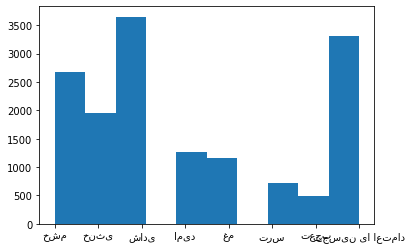

In [5]:
data_df = pd.read_csv('comp_dataset2.csv', index_col= False)
fig, ax = plt.subplots()
ax.hist(data_df['tag'])
plt.show()


In [6]:
# data_df = pd.read_excel('1e4_S_01.xlsx', index_col= False)
# fig, ax = plt.subplots()
# ax.hist(data_df['tag'])
# plt.show()


In [7]:
# call_cleantext = CleanText(data_df, 'متن توییت')
call_cleantext = CleanText(data_df, 'caption')
# call_cleantext = CleanText(data_df, 'Text')
get_pun_list = call_cleantext.clean_punctual()
get_ex_emoji = call_cleantext.extract_emojis()
get_emoji_list = call_cleantext.convert_emojies()
get_norm_list = call_cleantext.normalize_text()
get_rm_sw_list = call_cleantext.remove_stop_words()
get_most_com_list = call_cleantext.frequency_words()
# get_most_com_list = get_most_com_list
# Remove None Value Data

همسر من تو سکو نفتی کار می کنه ماموریت طولانی مدت می ره همه کارا رو دوش منه الان که مهد کودک تعطیل شده زندگی مثل جهنم شده
همسر من تو سکو نفتی کار می کنه ماموریت طولانی مدت می ره همه کارا رو دوش منه الان که مهد کودک تعطیل شده زندگی مثل جهنم شده
همسر من تو سکو نفتی کار می کنه ماموریت طولانی مدت می ره همه کارا رو دوش منه الان که مهد کودک تعطیل شده زندگی مثل جهنم شده
همسر من تو سکو نفتی کار می‌کنه ماموریت طولانی مدت می‌ره همه کارا رو دوش منه الان که مهد کودک تعطیل‌شده‌زندگی مثل جهنم شده
همسر سکو نفتی می‌کنه ماموریت طولانی مدت می‌ره کارا منه الان مهد کودک تعطیل‌شده‌زندگی جهنم شده
4000
{'مناطق', 'خوشحالم', 'تصور', 'تومن', 'لطف', 'سرداران', 'سربازان', 'کرده', 'فناوری', 'دهن', 'نگاهش', 'بی\u200cکفایتی', 'سالار', 'بگوید', 'بحث', 'میدهیم', 'تلگرام', 'اونوقت', 'لقب', 'میخوام', 'سلامی', 'کشورمون', 'روحی', 'زندان', 'ژاپن', 'هستیم', 'نشینان', 'العظمی', 'فرموده', 'امتیاز', 'جرقه', 'لرستان', 'آرام', 'وین', 'خیلی\u200cها', 'گلو', 'همراهی', 'مون', 'الکی', 'اصلا', 'مقابله', 'قوا', 'بدی', 'پایدار', 'کردی'

In [8]:
# init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['احساس'])))
# init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['tag'])))
init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['tag'])))
init_List_prepared = list(filter(lambda x: len(x[0])>1, init_List_prepared))

random.shuffle(init_List_prepared)

var1 = list(filter(lambda x: x[1]=='شادی', init_List_prepared))
var2 = list(filter(lambda x: x[1]=='خشم', init_List_prepared))
var3 = list(filter(lambda x: x[1]=='غم', init_List_prepared))
var4 = list(filter(lambda x: x[1]=='خنثی', init_List_prepared))
var5 = list(filter(lambda x: x[1]=='امید', init_List_prepared))
var6 = list(filter(lambda x: x[1]=='ترس', init_List_prepared))
var7 = list(filter(lambda x: x[1]=='تعجب', init_List_prepared))
var8 = list(filter(lambda x: x[1]=='تحسین یا اعتماد', init_List_prepared))

# List_prepared = var1[:1500]+var2[:1500]+var3[:1000]+var4[:1000]+var5[:1200]+var6[:700]+var7[:500]+var8[:1500]
List_prepared = var1+var2

# List_prepared = init_List_prepared

In [9]:
List_prepared[0]

['بزار بگیرم مرده کرونای هستم : چهره چشمان قلب :', 'شادی']

In [10]:
text, tag = zip(*List_prepared)
train_text, test_text, train_tag, test_tag = train_test_split(text, tag, test_size=0.2)

In [11]:
call_encodetext = EncodeText(train_text)
tokenizer = call_encodetext.create_tokenizer()
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
max_len = 100
encode_train_text = call_encodetext.encode_text(tokenizer, train_text, max_len)
encode_test_text = call_encodetext.encode_text(tokenizer, test_text, max_len)
encode_train_tag = call_encodetext.label_encoder(train_tag)
encode_test_tag = call_encodetext.label_encoder(test_tag)
num_cat = encode_train_tag.shape[1]

3401


In [14]:
#  CNN layer
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(num_cat, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          340100    
                                                                 
 conv1d (Conv1D)             (None, 93, 32)            25632     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 46, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense (Dense)               (None, 200)               294600    
                                                                 
 dense_1 (Dense)             (None, 20)                4020      
                                                        

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fitting Network
m = model.fit(encode_train_text, encode_train_tag, epochs=100, verbose=2)
# Evaluating Network
loss, acc = model.evaluate(encode_test_text, encode_test_tag, verbose=0)
print('Test Accuracy: %f' % (acc * 100))
print('Test loss: %f' % loss)
# !khashm, khonsa, shadi, gham of 1e4 51%

Epoch 1/100
149/149 - 2s - loss: 0.4361 - accuracy: 0.7884 - 2s/epoch - 14ms/step
Epoch 2/100
149/149 - 2s - loss: 0.1917 - accuracy: 0.9265 - 2s/epoch - 11ms/step
Epoch 3/100
149/149 - 2s - loss: 0.1040 - accuracy: 0.9624 - 2s/epoch - 11ms/step
Epoch 4/100
149/149 - 2s - loss: 0.0525 - accuracy: 0.9847 - 2s/epoch - 11ms/step
Epoch 5/100
149/149 - 2s - loss: 0.0318 - accuracy: 0.9910 - 2s/epoch - 13ms/step
Epoch 6/100
149/149 - 2s - loss: 0.0185 - accuracy: 0.9945 - 2s/epoch - 16ms/step
Epoch 7/100
149/149 - 2s - loss: 0.0127 - accuracy: 0.9962 - 2s/epoch - 12ms/step
Epoch 8/100
149/149 - 2s - loss: 0.0119 - accuracy: 0.9969 - 2s/epoch - 14ms/step
Epoch 9/100
149/149 - 2s - loss: 0.0098 - accuracy: 0.9964 - 2s/epoch - 13ms/step
Epoch 10/100
149/149 - 2s - loss: 0.0080 - accuracy: 0.9964 - 2s/epoch - 12ms/step
Epoch 11/100
149/149 - 2s - loss: 0.0071 - accuracy: 0.9975 - 2s/epoch - 12ms/step
Epoch 12/100
149/149 - 2s - loss: 0.0079 - accuracy: 0.9969 - 2s/epoch - 12ms/step
Epoch 13/100


In [ ]:
# with open('CNN_7_tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # # loading
# # with open('tokenizer.pickle', 'rb') as handle:
# #     tokenizer = pickle.load(handle)
# joblib.dump(model, 'CNN_7_model.joblib')


In [ ]:
# test_df = pd.DataFrame()
# test_df['train_text'] = train_text
# test_df['tag_text'] = train_tag
# test_df['encode_train_tag'] = encode_train_tag.tolist()
# test_df.to_excel('test_df.xlsx', index=False)

In [16]:
# tmp_df = pd.DataFrame()
# comment = train_text
# tmp_df['tmp_caption']=comment
# print(tmp_df)
# tmp_call_cleantext = CleanText(tmp_df, 'tmp_caption')
# tmp_get_ex_emoji = tmp_call_cleantext.extract_emojis()
# print(tmp_get_ex_emoji)
# tmp_get_emoji_list = tmp_call_cleantext.convert_emojies()
# tmp_get_norm_list = tmp_call_cleantext.normalize_text()
# print(tmp_get_norm_list)
#
# list_a = []
# i = 0
# for item in tmp_get_norm_list:
#     i += 1
#     # print(i)
#     comment_list = item
#     instance = tokenizer.texts_to_sequences(comment_list)
#     flat_list = []
#     for sublist in instance:
#         for item in sublist:
#             flat_list.append(item)
#
#     flat_list = [flat_list]
#
#     instance = pad_sequences(flat_list, padding='post', maxlen=max_len)
#
#     output = model.predict(instance)
#     list_a.append(output)
# # print(list_a)
# train_df = pd.DataFrame()
# train_df['train_text'] = train_text
# train_df['tag_text'] = train_tag
# train_df['encode_train_tag'] = encode_train_tag.tolist()
# train_df['my_model'] = list_a
# train_df.to_excel('train_df.xlsx', index=False)

<class 'list'>
                                            tmp_caption
0                                           همشون دروغه
1     دوست عزیز وقتی هیچی طراحی نظر میدی لطف کلا ماش...
2     بخواب بیند دشمنان برجام حوزه دفاعی مرگ امریکا ...
3                                                  خودت
4                     روز تحقیر ملت ذلت . روز خراب ملکت
...                                                 ...
4759                                      این دوست دارم
4760                                   اگه باید . همتون
4761  عزیز اون دست ادمای موسی اینای گفتی محض نیس فک ...
4762  راه مدرسه بحث « ناموس » شده‌بود ، گفتم ناموس م...
4763                                                خری

[4764 rows x 1 columns]
['همشون دروغه', 'دوست عزیز وقتی هیچی طراحی نظر میدی لطف کلا ماشین برسی نکن', 'بخواب بیند دشمنان برجام حوزه دفاعی مرگ امریکا مرگ اسرایل مرگ ال بهمن تماشای شانلی وطن', 'خودت', 'روز تحقیر ملت ذلت . روز خراب ملکت', 'اقای مدنی چرا صورت مسئله پاک میکنید ؟ ایا ایجاد یک انسانی میشه انسانی نامید 

In [19]:
# df = pd.read_excel('train_df.xlsx')
# list_b = df['my_model']
# list_c = list(map(lambda x: list(x[2:-2].split(" ")), list_b))
# list_c = list(map(lambda x: list(filter(None, x)), list_c))
#
# list_d = list(map(lambda x: [re.sub('\n','', i) for i in x], list_c))
#
# list_e = list(map(lambda x: [float(i) for i in x], list_d))
# list_f = list(map(lambda x: x.index(max(x)), list_e))
# train_df['my_model2'] = list_f
# train_df.to_excel('train_df.xlsx', index=False)

In [20]:
# # Reconstruct a new model from the final model:
# reconstructed_model = keras.models.load_model("x_model")
#
# # Reconstruct the set of losses and metric
# # in the already compiled final model, and test it:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )
#
# # Resume training on the reconstructed model:
# reconstructed_model.fit(test_input, test_target)

